In [ ]:
!pip install  transformers lazypredict

In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.1

In [ ]:
import os
import sys
import shutil
import tempfile
import urllib.request
import zipfile
from sklearn.metrics import log_loss, f1_score, roc_curve, auc


TASKS = ["CoLA", "SST", "RTE"]
TASK2PATH = {"CoLA":'https://dl.fbaipublicfiles.com/glue/data/CoLA.zip',
             "SST":'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip',
             "RTE":'https://dl.fbaipublicfiles.com/glue/data/RTE.zip'}

def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")
    

def get_tasks(task_names):
    if "all" in task_names:
        tasks = TASKS
    else:
        tasks = []
        for task_name in task_names:
            assert task_name in TASKS, "Task %s not found!" % task_name
            tasks.append(task_name)
    return tasks

def main():
    tasks = get_tasks('all')

    for task in tasks:
      download_and_extract(task, '/content/data')

main()

	Completed!
	Completed!
	Completed!


# RTE classifiers

Here we aim to try different simple hypothesis about data representation of two sentences to make the model to perform best.

In [ ]:
## RTE
import pandas as pd

data_pth = '/content/data'
TASKS = ["CoLA", "SST-2", "RTE"]

train_data = pd.read_table(os.path.join(data_pth, TASKS[2], 'train.tsv'))
test_data = pd.read_table(os.path.join(data_pth, TASKS[2], 'dev.tsv'))

In [ ]:
train_data

,index,sentence1,sentence2,label
0,0,No Weapons of Mass Destruction Found in Iraq Yet.,Weapons of Mass Destruction Found in Iraq.,not_entailment
1,1,"A place of sorrow, after Pope John Paul II die...",Pope Benedict XVI is the new leader of the Rom...,entailment
2,2,Herceptin was already approved to treat the si...,Herceptin can be used to treat breast cancer.,entailment
3,3,"Judie Vivian, chief executive at ProMedica, a ...",The previous name of Ho Chi Minh City was Saigon.,entailment
4,4,A man is due in court later charged with the m...,Paul Stewart Hutchinson is accused of having s...,not_entailment
...,...,...,...,...
2485,2485,There is none. They found as many weapons in t...,Weapons of mass destruction found in Iraq.,not_entailment
2486,2486,"Dr. Eric Goosby, a pioneer in the fight agains...",Pepfar is committed to fighting AIDS.,entailment
2487,2487,"NASA's Saturn exploration spacecraft, Cassini ...",Titan is the fifteenth of Saturn's known satel...,not_entailment
2488,2488,Brooklyn Borough Hall featured a Who's Who in ...,The Brooklyn Book Festival is held in Brooklyn...,entailment


In [ ]:
sent1 = train_data.loc[:,'sentence1']
sent2 = train_data.loc[:,'sentence2']
x_train = [(sent1[i], sent2[i]) for i in range(train_data.shape[0])]
y_train = train_data.loc[:,'label']
sent1 = test_data.loc[:,'sentence1']
sent2 = test_data.loc[:,'sentence2']
x_test = [(sent1[i], sent2[i]) for i in range(test_data.shape[0])]
y_test = test_data.loc[:,'label']

In [ ]:
len(y_test)

277

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

stop_words = set(stopwords.words('english'))
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

def sent_preprocess(sentence):
  word_tokens = word_tokenize(sentence)
  filtered_sentence = [w.lower() for w in word_tokens if w not in stop_words]
  
  tokens = {'input_ids': [], 'attention_mask': []}

  new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                      truncation=True, padding='max_length',
                                      return_tensors='pt')
  tokens['input_ids'].append(new_tokens['input_ids'][0])
  tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask

  mean_pooled = mean_pooled.detach().numpy()

  return mean_pooled

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def find_similarity(sentences):
  tokens = {'input_ids': [], 'attention_mask': []}

  for sentence in sentences:
      new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                        truncation=True, padding='max_length',
                                        return_tensors='pt')
      tokens['input_ids'].append(new_tokens['input_ids'][0])
      tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask


  mean_pooled = mean_pooled.detach().numpy()
  cosine_array = cosine_similarity(
      [mean_pooled[0]],
      mean_pooled[1:]
  )

  return cosine_array.sum()/(len(sentences)-1)

In [ ]:
import tqdm
cos_dict = []

for item in tqdm.tqdm(x_train):
  sentences = [
      item[0],
      item[1]
  ]
  cos_dict.append(find_similarity(sentences))

100%|██████████| 2490/2490 [38:22<00:00,  1.08it/s]


In [ ]:
import numpy as np

y_train = y_train.replace('not_entailment', 0)
y_train = y_train.replace('entailment', 1)

print(y_train)

y_test = y_test.replace('not_entailment', 0)
y_test = y_test.replace('entailment', 1)

print(y_test)

0      0.00
1      1.00
2      1.00
3      1.00
4      0.00
       ... 
2236   1.00
2237   0.00
2238   0.00
2239   1.00
2240   1.00
Name: label, Length: 2241, dtype: float64
0      0
1      1
2      0
3      0
4      1
      ..
272    1
273    1
274    1
275    1
276    0
Name: label, Length: 277, dtype: int64


Here we aim to assess the dependence between cosine distance and data distribution. The assumption is the higher cosine distance the closer data to label 'entailment'. 

But the plot indicates there is no correlation between these variables. Possible explanations might be due to high data dimensionality or too complex dependence.

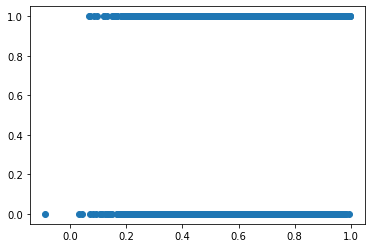

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cos_dict, y_train.values, 'o')
plt.show()

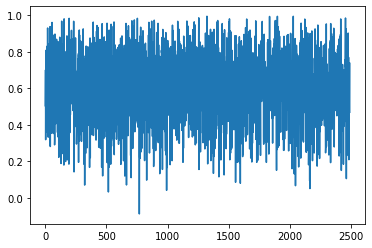

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cos_dict)
plt.show()

## **Representation Substruction**

Assumprion: difference of features of representation of two sentences might be enought to train classifiers how to distinguich one class from another.

In [ ]:
def find_similarity(sentences):
  tokens = {'input_ids': [], 'attention_mask': []}

  for sentence in sentences:
      new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                        truncation=True, padding='max_length',
                                        return_tensors='pt')
      tokens['input_ids'].append(new_tokens['input_ids'][0])
      tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask


  mean_pooled = mean_pooled.detach().numpy()

  return mean_pooled[0] - mean_pooled[1]

In [ ]:
import tqdm

x_train_preprocessed = [find_similarity(sent) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [find_similarity(sent) for sent in tqdm.tqdm(x_test)]


100%|██████████| 2490/2490 [39:32<00:00,  1.05it/s]

100%|██████████| 277/277 [04:24<00:00,  1.05it/s]


In [ ]:
size = 2241
vector_size = 768

x_valid_preprocessed = x_train_preprocessed[size:len(x_train)]
x_train_preprocessed = x_train_preprocessed[0:size]

y_valid = y_train[size:len(x_train)]
y_train = y_train[0:size]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

249
2241
249
2241


In [ ]:
# print((x_valid_preprocessed))
# print((x_train_preprocessed))

# y_train = train_data.loc[:,'label']
# y_train = y_train[0:size]

# y_train = y_train.replace('not_entailment', 0)
# y_train = y_train.replace('entailment', 1)

# y_valid = y_valid.replace('not_entailment', 0)
# y_valid = y_valid.replace('entailment', 1)

print(y_valid)
# print((y_train==np.inf).describe())
print(y_train.fillna(0).astype('int64'))
print(y_test)

2241    0
2242    1
2243    1
2244    1
2245    0
       ..
2485    0
2486    1
2487    0
2488    1
2489    0
Name: label, Length: 249, dtype: int64
0       0
1       1
2       1
3       1
4       0
       ..
2236    1
2237    0
2238    0
2239    1
2240    1
Name: label, Length: 2241, dtype: int64
0      0
1      1
2      0
3      0
4      1
      ..
272    1
273    1
274    1
275    1
276    0
Name: label, Length: 277, dtype: int64


### **General classifiers**

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np


clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#models,predictions = clf.fit(df_train, df_test, y_train, y_test)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train.fillna(0).astype('int64'), y_valid)


print(models)

100%|██████████| 29/29 [02:30<00:00,  5.19s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.64               0.64     0.64      0.64   
ExtraTreesClassifier               0.64               0.64     0.64      0.64   
GaussianNB                         0.63               0.63     0.63      0.62   
LGBMClassifier                     0.63               0.63     0.63      0.63   
NuSVC                              0.62               0.62     0.62      0.62   
AdaBoostClassifier                 0.60               0.60     0.60      0.60   
XGBClassifier                      0.59               0.59     0.59      0.59   
RandomForestClassifier             0.58               0.58     0.58      0.58   
RidgeClassifierCV                  0.57               0.57     0.57      0.57   
BernoulliNB                        0.57               0.57     0.57      0.57   
RidgeClassifier             

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train.fillna(0).astype('int64'), y_valid)
predictions = models['ExtraTreesClassifier'].predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

163 277


BERT, best general classifier, substraction
F-measure or f1-score:  0.6174496644295302
Log loss:  14.214687670995051
AUC:  0.5860608595628987
Classification Report:
              precision    recall  f1-score   support

           1     0.6053    0.6301    0.6174       146
           0     0.5680    0.5420    0.5547       131

    accuracy                         0.5884       277
   macro avg     0.5866    0.5861    0.5861       277
weighted avg     0.5876    0.5884    0.5878       277



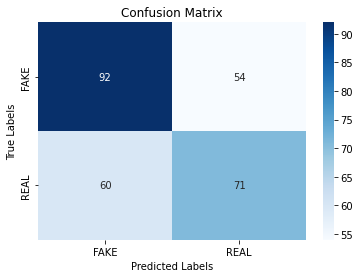

In [ ]:
from sklearn.metrics import log_loss, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def eval(y_true, y_pred):
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
# model evaluation

print("BERT, best general classifier, substraction")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

# y_train = y_train.fillna(0).astype('int64')

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,768]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,768]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
18/18 [==============================] - 13s 260ms/step - loss: 0.7048 - val_loss: 0.6651
Epoch 2/50
18/18 [==============================] - 4s 212ms/step - loss: 0.6145 - val_loss: 0.6561
Epoch 3/50
18/18 [==============================] - 5s 267ms/step - loss: 0.5654 - val_loss: 0.6352
Epoch 4/50
18/18 [==============================] - 5s 268ms/step - loss: 0.5012 - val_loss: 0.6847
Epoch 5/50
18/18 [==============================] - 5s 277ms/step - loss: 0.4236 - val_loss: 0.6725
Epoch 6/50
18/18 [==============================] - 5s 283ms/step - loss: 0.3437 - val_loss: 0.7227
Epoch 7/50
18/18 [==============================] - 5s 278ms/step - loss: 0.2685 - val_loss: 0.7847
Epoch 8/50
18/18 [==============================] - 5s 270ms/step - loss: 0.1905 - val_loss: 0.8234
Epoch 9/50
18/18 [==============================] - 6s 332ms/step - loss: 0.1312 - val_loss: 0.9799
Epoch 10/50
18/18 [==============================] - 6s 332ms/step - loss: 0.1085 - val_loss: 0.948

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,768]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

146 277


BERT, LSTM, substraction
F-measure or f1-score:  0.690307328605201
Log loss:  nan
Log loss:  16.334600920565542
AUC:  0.533253163233295
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5271    1.0000    0.6903       146
           0     0.0000    0.0000    0.0000       131

    accuracy                         0.5271       277
   macro avg     0.2635    0.5000    0.3452       277
weighted avg     0.2778    0.5271    0.3638       277



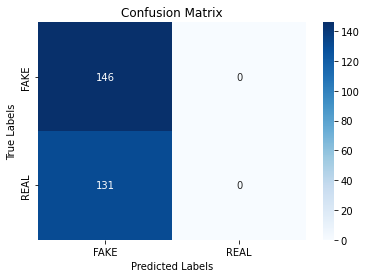

In [ ]:
# model evaluation

print("BERT, LSTM, substraction")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])




## **Representation addition**

Assumprion: averaged addition of features of representation of two sentences might be enought to train classifiers how to distinguich one class from another.

In [ ]:
sent1 = train_data.loc[:,'sentence1']
sent2 = train_data.loc[:,'sentence2']
x_train = [(sent1[i], sent2[i]) for i in range(train_data.shape[0])]
y_train = train_data.loc[:,'label']
sent1 = test_data.loc[:,'sentence1']
sent2 = test_data.loc[:,'sentence2']
x_test = [(sent1[i], sent2[i]) for i in range(test_data.shape[0])]
y_test = test_data.loc[:,'label']

In [ ]:
def find_similarity(sentences):
  tokens = {'input_ids': [], 'attention_mask': []}

  for sentence in sentences:
      new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                        truncation=True, padding='max_length',
                                        return_tensors='pt')
      tokens['input_ids'].append(new_tokens['input_ids'][0])
      tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask


  mean_pooled = mean_pooled.detach().numpy()

  return (mean_pooled[0] + mean_pooled[1])/2

In [ ]:
import tqdm

x_train_preprocessed = [find_similarity(sent) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [find_similarity(sent) for sent in tqdm.tqdm(x_test)]



  0%|          | 0/2490 [00:00<?, ?it/s]

  0%|          | 1/2490 [00:02<1:32:18,  2.23s/it]

  0%|          | 2/2490 [00:04<1:28:14,  2.13s/it]

  0%|          | 3/2490 [00:06<1:24:14,  2.03s/it]

  0%|          | 4/2490 [00:07<1:17:58,  1.88s/it]

  0%|          | 5/2490 [00:09<1:13:57,  1.79s/it]

  0%|          | 6/2490 [00:10<1:10:06,  1.69s/it]

  0%|          | 7/2490 [00:12<1:13:34,  1.78s/it]

  0%|          | 8/2490 [00:15<1:18:27,  1.90s/it]

  0%|          | 9/2490 [00:17<1:26:02,  2.08s/it]

  0%|          | 10/2490 [00:20<1:37:50,  2.37s/it]

  0%|          | 11/2490 [00:23<1:41:24,  2.45s/it]

  0%|          | 12/2490 [00:25<1:33:59,  2.28s/it]

  1%|          | 13/2490 [00:26<1:18:58,  1.91s/it]

  1%|          | 14/2490 [00:27<1:07:05,  1.63s/it]

  1%|          | 15/2490 [00:28<58:45,  1.42s/it]  

  1%|          | 16/2490 [00:29<52:57,  1.28s/it]

  1%|          | 17/2490 [00:30<49:17,  1.20s/it]

  1%|          | 18/2490 [00:31<46:26,  1.13s/it]

  1%|          | 

In [ ]:
size = 2241
vector_size = 768

x_valid_preprocessed = x_train_preprocessed[size:len(x_train)]
x_train_preprocessed = x_train_preprocessed[0:size]

y_valid = y_train[size:len(x_train)]
y_train = y_train[0:size]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

249
2241
249
2241


In [ ]:
# y_train = train_data.loc[:,'label']
# y_train = y_train[0:size]

y_train = y_train.replace('not_entailment', 0)
y_train = y_train.replace('entailment', 1)

y_valid = y_valid.replace('not_entailment', 0)
y_valid = y_valid.replace('entailment', 1)

y_test = y_test.replace('not_entailment', 0)
y_test = y_test.replace('entailment', 1)

### **General classifiers**

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np


clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#models,predictions = clf.fit(df_train, df_test, y_train, y_test)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train.fillna(0).astype('int64'), y_valid)


print(models)

100%|██████████| 29/29 [02:07<00:00,  4.40s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.58               0.58     0.58      0.58   
NuSVC                              0.58               0.58     0.58      0.58   
XGBClassifier                      0.57               0.57     0.57      0.57   
SVC                                0.57               0.57     0.57      0.57   
RandomForestClassifier             0.57               0.57     0.57      0.57   
NearestCentroid                    0.56               0.56     0.56      0.56   
QuadraticDiscriminantAnalysis      0.55               0.55     0.55      0.55   
BernoulliNB                        0.55               0.55     0.55      0.55   
GaussianNB                         0.55               0.55     0.55      0.55   
AdaBoostClassifier                 0.55               0.55     0.55      0.55   
ExtraTreesClassifier        

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train.fillna(0).astype('int64'), y_valid)
predictions = models['NuSVC'].predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

138 277


BERT, best general classifier, substraction
F-measure or f1-score:  0.5156794425087109
Log loss:  17.33192596361158
AUC:  0.497699466694552
Classification Report:
              precision    recall  f1-score   support

           1     0.5248    0.5068    0.5157       146
           0     0.4706    0.4885    0.4794       131

    accuracy                         0.4982       277
   macro avg     0.4977    0.4977    0.4975       277
weighted avg     0.4992    0.4982    0.4985       277



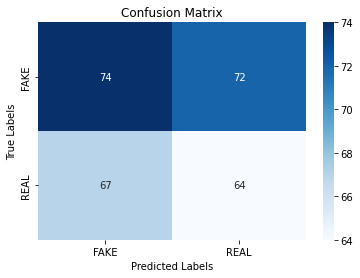

In [ ]:
from sklearn.metrics import log_loss, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def eval(y_true, y_pred):
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
# model evaluation

print("BERT, best general classifier, substraction")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

y_train = y_train.fillna(0).astype('int64')

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,768]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,768]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
18/18 [==============================] - 13s 239ms/step - loss: 0.7282 - val_loss: 0.6941
Epoch 2/50
18/18 [==============================] - 3s 187ms/step - loss: 0.6723 - val_loss: 0.6902
Epoch 3/50
18/18 [==============================] - 3s 186ms/step - loss: 0.6573 - val_loss: 0.7049
Epoch 4/50
18/18 [==============================] - 3s 191ms/step - loss: 0.6422 - val_loss: 0.7118
Epoch 5/50
18/18 [==============================] - 3s 188ms/step - loss: 0.6147 - val_loss: 0.7134
Epoch 6/50
18/18 [==============================] - 3s 187ms/step - loss: 0.5707 - val_loss: 0.7867
Epoch 7/50
18/18 [==============================] - 3s 188ms/step - loss: 0.5413 - val_loss: 0.7786
Epoch 8/50
18/18 [==============================] - 4s 198ms/step - loss: 0.4975 - val_loss: 0.7803
Epoch 9/50
18/18 [==============================] - 5s 276ms/step - loss: 0.4483 - val_loss: 0.8439


In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,768]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

  0%|          | 3/2490 [1:20:50<1116:59:25, 1616.87s/it]


146 277


BERT, LSTM, addition
F-measure or f1-score:  0.690307328605201
Log loss:  0.9303825712756049
Log loss:  16.334600920565542
AUC:  0.5174108543344139
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5271    1.0000    0.6903       146
           0     0.0000    0.0000    0.0000       131

    accuracy                         0.5271       277
   macro avg     0.2635    0.5000    0.3452       277
weighted avg     0.2778    0.5271    0.3638       277



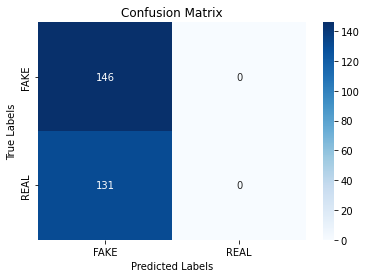

In [ ]:
# model evaluation

print("BERT, LSTM, addition")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])




## **Representation concatination**

Assumprion: concatination of features of representation of two sentences might be sufficient to train classifiers how to distinguich one class from another.

In [ ]:
sent1 = train_data.loc[:,'sentence1']
sent2 = train_data.loc[:,'sentence2']
x_train = [(sent1[i], sent2[i]) for i in range(train_data.shape[0])]
y_train = train_data.loc[:,'label']
sent1 = test_data.loc[:,'sentence1']
sent2 = test_data.loc[:,'sentence2']
x_test = [(sent1[i], sent2[i]) for i in range(test_data.shape[0])]
y_test = test_data.loc[:,'label']

In [ ]:
def find_similarity(sentences):
  tokens = {'input_ids': [], 'attention_mask': []}

  for sentence in sentences:
      new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                        truncation=True, padding='max_length',
                                        return_tensors='pt')
      tokens['input_ids'].append(new_tokens['input_ids'][0])
      tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask


  mean_pooled = mean_pooled.detach().numpy()

  return mean_pooled

In [ ]:
import tqdm

x_train_preprocessed = [find_similarity(sent) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [find_similarity(sent) for sent in tqdm.tqdm(x_test)]


100%|██████████| 2490/2490 [40:01<00:00,  1.04it/s]

100%|██████████| 277/277 [04:18<00:00,  1.07it/s]


In [ ]:
print(len(x_train_preprocessed))
print(x_train_preprocessed[0].flatten().shape)

# temp = x_train_preprocessed
# temp_test = x_test_preprocessed


x_train_preprocessed = [x.flatten() for x in x_train_preprocessed]
x_test_preprocessed = [x.flatten() for x in x_test_preprocessed]

2490
(1536,)


In [ ]:
size = 2241
vector_size = 1536

x_valid_preprocessed = x_train_preprocessed[size:len(x_train)]
x_train_preprocessed = x_train_preprocessed[0:size]

y_valid = y_train[size:len(x_train)]
y_train = y_train[0:size]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

249
2241
249
2241


In [ ]:
# y_train = train_data.loc[:,'label']
# y_train = y_train[0:size]

y_train = y_train.replace('not_entailment', 0)
y_train = y_train.replace('entailment', 1)

y_valid = y_valid.replace('not_entailment', 0)
y_valid = y_valid.replace('entailment', 1)

y_test = y_test.replace('not_entailment', 0)
y_test = y_test.replace('entailment', 1)

### **General classifiers**

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np


clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#models,predictions = clf.fit(df_train, df_test, y_train, y_test)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train.fillna(0).astype('int64'), y_valid)


print(models)


100%|██████████| 29/29 [03:58<00:00,  8.22s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.62               0.62     0.62      0.62   
NuSVC                              0.61               0.61     0.61      0.61   
ExtraTreesClassifier               0.61               0.61     0.61      0.61   
SGDClassifier                      0.61               0.61     0.61      0.61   
LogisticRegression                 0.61               0.61     0.61      0.61   
GaussianNB                         0.60               0.60     0.60      0.60   
KNeighborsClassifier               0.59               0.59     0.59      0.59   
NearestCentroid                    0.59               0.59     0.59      0.59   
Perceptron                         0.58               0.58     0.58      0.58   
BernoulliNB                        0.58               0.58     0.58      0.58   
CalibratedClassifierCV      

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train.fillna(0).astype('int64'), y_valid)
predictions = models['SVC'].predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

149 277


BERT, best general classifier, substraction
F-measure or f1-score:  0.5555555555555555
Log loss:  15.960335572524329
AUC:  0.5373313813656801
Classification Report:
              precision    recall  f1-score   support

           1     0.5634    0.5479    0.5556       146
           0     0.5111    0.5267    0.5188       131

    accuracy                         0.5379       277
   macro avg     0.5372    0.5373    0.5372       277
weighted avg     0.5387    0.5379    0.5382       277



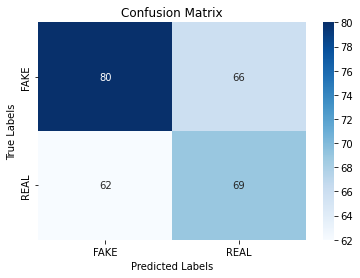

In [ ]:
from sklearn.metrics import log_loss, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def eval(y_true, y_pred):
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
# model evaluation

print("BERT, best general classifier, substraction")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

y_train = y_train.fillna(0).astype('int64')

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
18/18 [==============================] - 10s 292ms/step - loss: 0.7597 - val_loss: 0.6913
Epoch 2/50
18/18 [==============================] - 4s 237ms/step - loss: 0.6800 - val_loss: 0.6856
Epoch 3/50
18/18 [==============================] - 4s 240ms/step - loss: 0.6560 - val_loss: 0.6818
Epoch 4/50
18/18 [==============================] - 4s 237ms/step - loss: 0.6115 - val_loss: 0.6765
Epoch 5/50
18/18 [==============================] - 4s 240ms/step - loss: 0.5424 - val_loss: 0.7306
Epoch 6/50
18/18 [==============================] - 4s 240ms/step - loss: 0.4560 - val_loss: 0.7386
Epoch 7/50
18/18 [==============================] - 4s 238ms/step - loss: 0.3703 - val_loss: 0.7873
Epoch 8/50
18/18 [==============================] - 4s 241ms/step - loss: 0.2730 - val_loss: 0.8043
Epoch 9/50
18/18 [==============================] - 4s 238ms/step - loss: 0.2034 - val_loss: 0.8580
Epoch 10/50
18/18 [==============================] - 4s 239ms/step - loss: 0.1607 - val_loss: 0.903

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

146 277


BERT, LSTM, addition
F-measure or f1-score:  0.690307328605201
Log loss:  1.1685244797235976
Log loss:  16.334600920565542
AUC:  0.5475792115444944
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5271    1.0000    0.6903       146
           0     0.0000    0.0000    0.0000       131

    accuracy                         0.5271       277
   macro avg     0.2635    0.5000    0.3452       277
weighted avg     0.2778    0.5271    0.3638       277



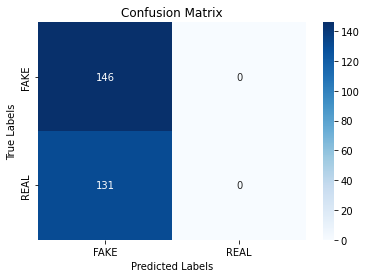

In [ ]:
# model evaluation

print("BERT, LSTM, addition")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])


